# Automatic Impression Generation From Medical Imaging Report

# 1. Business Problem

## Description

## Open-i chest X-ray collection from Indiana University

Open-i (Open Access Biomedical Image Search Engine) service of the National Library of Medicine enables search and retrieval of abstracts and images (including charts, graphs, clinical images, etc.) from the open source literature, and biomedical image collections. Searching may be done using text queries as well as query images. Open-i provides access to over 3.7 million images from about 1.2 million PubMed Central® articles; 7,470 chest x-rays with 3,955 radiology reports; 67,517 images from NLM History of Medicine collection; and 2,064 orthopedic illustrations.

## Introduction about Dataset

This dataset is about 1000 radiology reports for the chest x-ray images from indiana university hospital network.
- Images are downloaded as png format
- Reports are downloaded as xml format.
- Each xml will have the report for corresponding patient.
- To identify images associated with the reports we need to check the xml tag `<parentImages id="image-id">` id attribute we have the image name corresponding to the png images.
- More than one mages could be associated with one report.

Original data source: https://openi.nlm.nih.gov/  
Other Resources: https://www.kaggle.com/raddar/chest-xrays-indiana-university  

## Problem statement :
<p>Generation of Impression from given medical imaging report (Chest X-Ray)</p>

# 2. Deep Learning Problem Formulation

## Data Overview
## Dataset Preparation from raw report

Data are in xml format. Need to do xml parsing to read the data and convert it into csv format  

Image as input data with that We will also be taking the abstract, comparison, indication, findings as text inputs.  
Impression as output/target variable it is a text data.

__Below is the sample image and the report.__

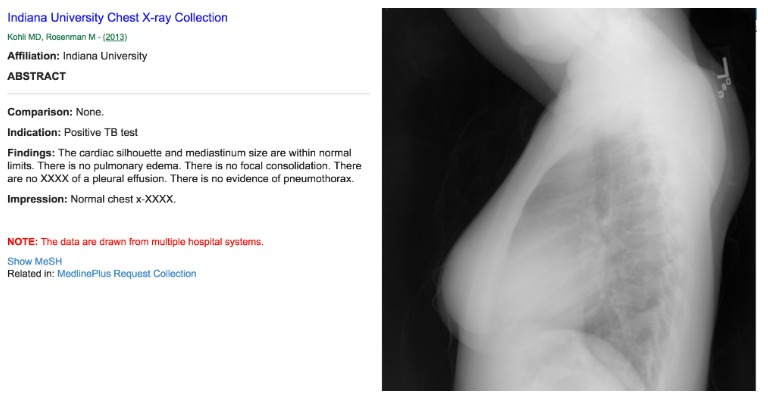

In [4]:
from IPython.display import Image
Image(filename='x-ray.jpeg')

# 3. Performance Metric

- I will be using Bleu Score for evaluation  
- Training loss Sparse categorical cross entropy

In [64]:
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 4. Data Preparation from raw xml data

In [9]:
#remove HTML from the Text column and save in the Text column only
def preprocess_text(data, isCaption):
    # Combining all the above stundents 
    preprocessed_reviews_eng = []

    # tqdm is for printing the status bar
    for sentance in tqdm(data.values):
        sentance = sentance.lower()
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = re.sub(r",", " ", sentance)
        sentance = re.sub(r"xxxx", "", sentance)
        sentance = re.sub(r"xxxxx", "", sentance)
        sentance = re.sub(r'[0-9]',"",sentance)
        sentance = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?$%^&*'/+\[\]_]+", "", sentance)
        sentance = re.sub(r"yearold", "", sentance)
        sentance = re.sub('\s+',' ',sentance)
        #if not isCaption:
            #sentance = '<start> ' + sentance + ' <end>'
        preprocessed_reviews_eng.append(sentance.strip())
    return preprocessed_reviews_eng

In [10]:
columns = ["image_name", "image_caption", "comparison", "indication", "findings", "impression"]
dataframe = pd.DataFrame(columns = columns)
#list files from Directory
for file in tqdm(os.listdir("ecgen-radiology/")):
    #find files ends with .xml only
    if file.endswith(".xml"):
        #parse the xml file 
        tree = ET.parse("ecgen-radiology/"+file)
        #find images in each parentImage tag
        img_list = set()
        cap_list = set()
        for parent in tree.findall("parentImage"):
            img = parent.attrib['id']+".png"
            #for each image iterate and add the corresponding report
                #reading hight and width for image
            h = mpimg.imread("img/"+img).shape[0]
            w = mpimg.imread("img/"+img).shape[1]
            cap_list.add('' if parent.find('caption').text is None else parent.find('caption').text)
            img_list.add(img)
        # finding root element
        tree = ET.parse("ecgen-radiology/"+file)
        comparision = tree.find(".//AbstractText[@Label='COMPARISON']").text
        indication = tree.find(".//AbstractText[@Label='INDICATION']").text
        findings = tree.find(".//AbstractText[@Label='FINDINGS']").text
        impression = tree.find(".//AbstractText[@Label='IMPRESSION']").text
        text_mesh = ""
        i = 1
        for child in tree.find("MeSH"):
            if len(tree.find("MeSH")) == i:
                text_mesh += child.text
            else:
                text_mesh += child.text+" "
            i+=1
        # add reports and image details to dataframe
        dataframe = dataframe.append(pd.Series([','.join(img_list), ','.join(cap_list), comparision, indication, findings, impression],
                                                         index = columns), ignore_index = True)

100%|██████████████████████████████████████████████████████████████████████████████| 3956/3956 [01:54<00:00, 34.68it/s]


In [11]:
dataframe.head()

,image_name,image_caption,comparison,indication,findings,impression
0,"CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png",Xray Chest PA and Lateral,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,"CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png",PA and lateral chest x-XXXX XXXX.,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
2,"CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png","CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM",None.,None,Both lungs are clear and expanded. Heart and m...,No active disease.
3,"CXR1000_IM-0003-2001.png,CXR1000_IM-0003-1001....",PA and lateral chest x-XXXX XXXX.,XXXX PA and lateral chest radiographs,"XXXX-year-old male, XXXX.",There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...
4,"CXR1001_IM-0004-1002.png,CXR1001_IM-0004-1001.png","CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM",None,"dyspnea, subjective fevers, arthritis, immigra...",Interstitial markings are diffusely prominent ...,Diffuse fibrosis. No visible focal acute disease.


In [12]:
dataframe['image_caption'] = preprocess_text(dataframe['image_caption'].fillna('Unknown'), True)
dataframe['comparison'] = preprocess_text(dataframe['comparison'].fillna('No Comparison'), False)
dataframe['indication'] = preprocess_text(dataframe['indication'].fillna('No Indication'), False)
dataframe['findings'] = preprocess_text(dataframe['findings'].fillna('No Findings'), False)
dataframe['impression'] = preprocess_text(dataframe['impression'].fillna('No Impression'), False)

100%|████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:00<00:00, 4589.82it/s]


In [13]:
dataframe.head()

,image_name,image_caption,comparison,indication,findings,impression
0,"CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png",xray chest pa and lateral,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x
1,"CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png",pa and lateral chest x,chest radiographs,male chest pain,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process
2,"CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png",chest v frontallateral pm,none,no indication,both lungs are clear and expanded heart and me...,no active disease
3,"CXR1000_IM-0003-2001.png,CXR1000_IM-0003-1001....",pa and lateral chest x,pa and lateral chest radiographs,male,there is increased opacity within the right up...,increased opacity in the right upper lobe with...
4,"CXR1001_IM-0004-1002.png,CXR1001_IM-0004-1001.png",chest v frontallateral pm,none,dyspnea subjective fevers arthritis immigrant ...,interstitial markings are diffusely prominent ...,diffuse fibrosis no visible focal acute disease


In [14]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3955 entries, 0 to 3954
Data columns (total 6 columns):
image_name       3955 non-null object
image_caption    3955 non-null object
comparison       3955 non-null object
indication       3955 non-null object
findings         3955 non-null object
impression       3955 non-null object
dtypes: object(6)
memory usage: 185.5+ KB


In [32]:
dataframe.image_name.describe()

count     3955
unique    3852
top           
freq       104
Name: image_name, dtype: object

- There are some empty cells in image name column

__Drop Missing image rows__

In [33]:
dataframe.replace("", float("NaN"), inplace=True)
dataframe.dropna(subset = ["image_name"], inplace=True)
dataframe.shape

(3851, 8)

__create word count column for findings and impression__

In [34]:
dataframe['findings_count'] = dataframe['findings'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
dataframe['impression_count'] = dataframe['impression'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))

In [46]:
dataframe['image_count'] = dataframe['image_name'].astype(str).str.split(',').apply(len)

In [47]:
dataframe.to_csv("data.csv", index=False)

In [65]:
data = pd.read_csv("data.csv")

In [66]:
data.head()

,image_name,image_caption,comparison,indication,findings,impression,findings_count,impression_count,image_count
0,"CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png",xray chest pa and lateral,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x,33,3,2
1,"CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png",pa and lateral chest x,chest radiographs,male chest pain,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process,38,4,2
2,"CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png",chest v frontallateral pm,none,no indication,both lungs are clear and expanded heart and me...,no active disease,10,3,2
3,"CXR1000_IM-0003-2001.png,CXR1000_IM-0003-1001....",pa and lateral chest x,pa and lateral chest radiographs,male,there is increased opacity within the right up...,increased opacity in the right upper lobe with...,52,36,3
4,"CXR1001_IM-0004-1002.png,CXR1001_IM-0004-1001.png",chest v frontallateral pm,none,dyspnea subjective fevers arthritis immigrant ...,interstitial markings are diffusely prominent ...,diffuse fibrosis no visible focal acute disease,14,7,2


In [50]:
print("Shape of the dataframe ", data.shape)

Shape of the dataframe  (3851, 9)


In [51]:
print("Total number of unique Images {} ".format(len(data.image_name.unique())))
print("Total number of unique Caption {} ".format(len(data.image_caption.unique())))
print("Total number of unique Comparison {} ".format(len(data.comparison.unique())))
print("Total number of unique Indication {} ".format(len(data.indication.unique())))
print("Total number of unique Findings {} ".format(len(data.findings.unique())))
print("Total number of unique Impression {} ".format(len(data.impression.unique())))

Total number of unique Images 3851 
Total number of unique Caption 402 
Total number of unique Comparison 281 
Total number of unique Indication 2098 
Total number of unique Findings 2545 
Total number of unique Impression 1692 


# 5. EDA on Text data

## Lets see top 100 most occurring sentences

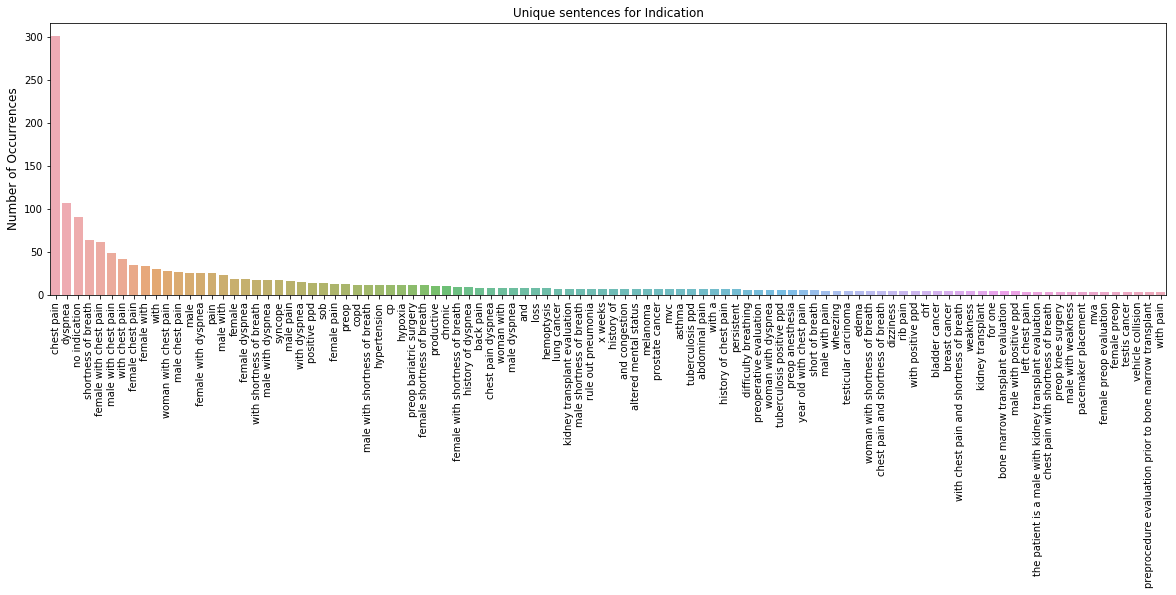

In [82]:
indication = data.indication.value_counts()[:100]
plt.figure(figsize=(20,5))
sns.barplot(indication.index, indication.values, alpha=0.8)
plt.title("Unique sentences for Indication")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=90)
plt.show()

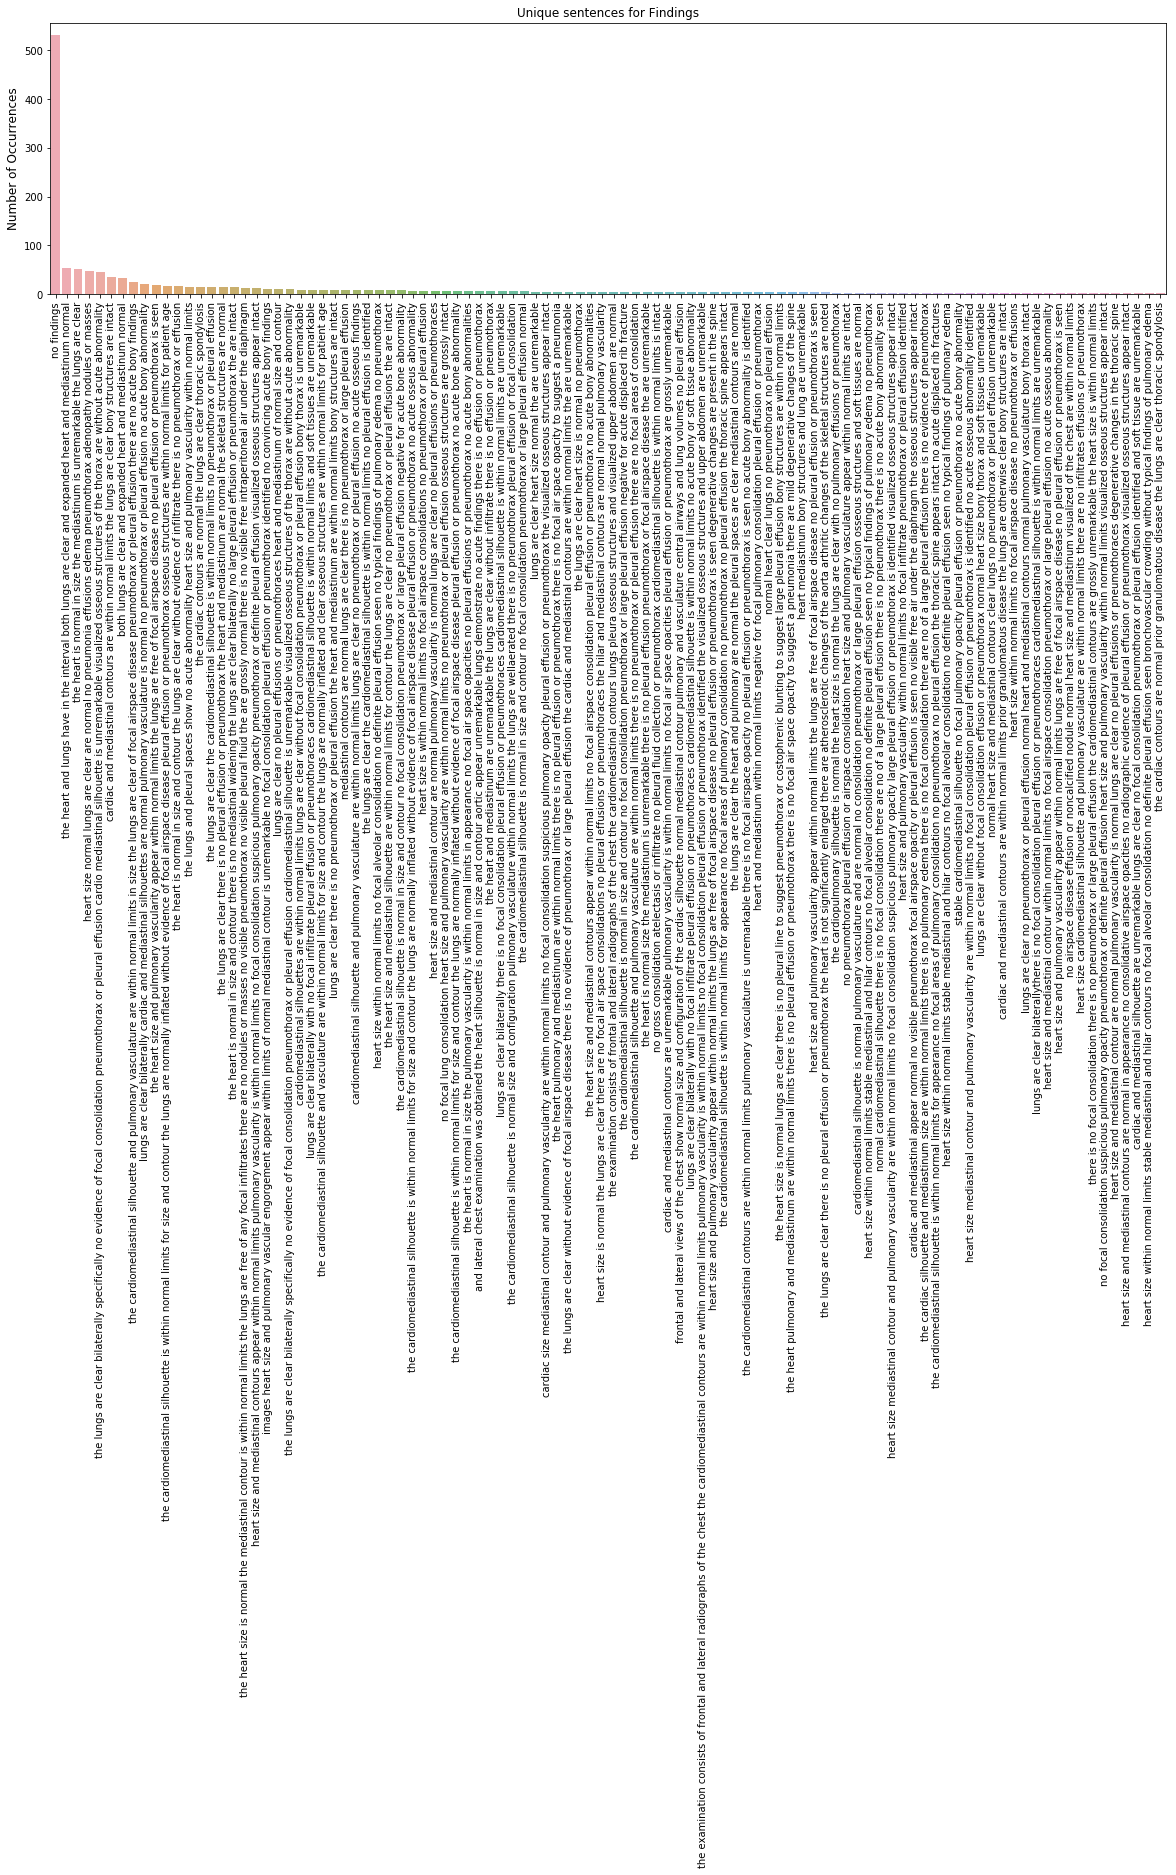

In [83]:
findings = data.findings.value_counts()[:100]
plt.figure(figsize=(20,5))
sns.barplot(findings.index, findings.values, alpha=0.8)
plt.title("Unique sentences for Findings")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- There is more then 500 rows have no findings
- From above distribution we can see that there are 4 unique sentences which occurred more than 60 times.
- Most of the sentences are occurred almost 10 times

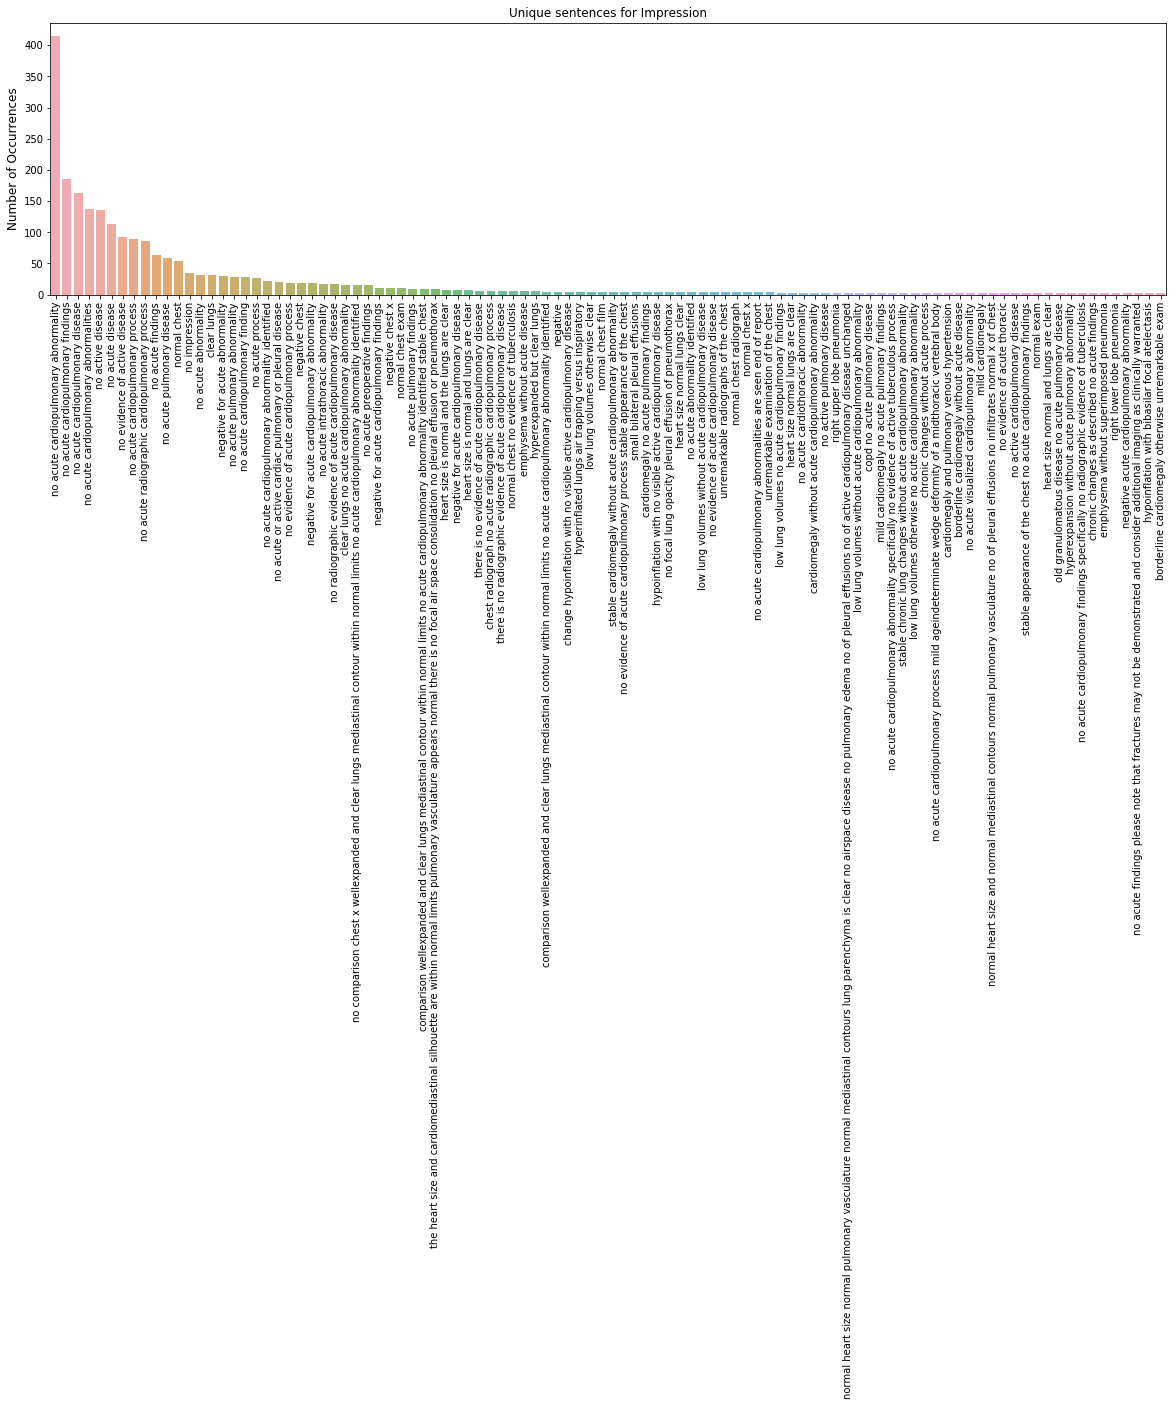

In [84]:
impression = data.impression.value_counts()[:100]
plt.figure(figsize=(20,5))
sns.barplot(impression.index, impression.values, alpha=0.8)
plt.title("Unique sentences for Impression")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- From above distribution we can see that "No acute cardiopulmonary abnormality" occurred 600 times.
- Most of the sentences are occurred almost 10 times

## Word cloud max 1000 words on Indication

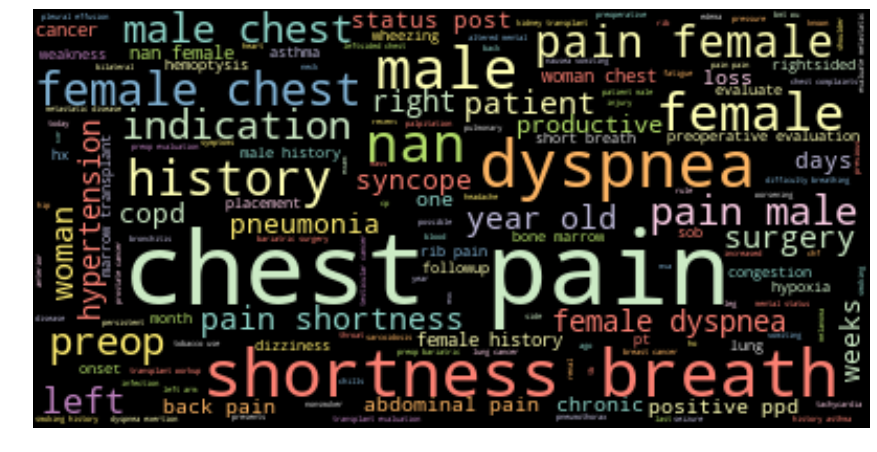

In [85]:
from wordcloud import WordCloud, ImageColorGenerator
wordcloud = WordCloud(max_words=1000,colormap='Set3', background_color="black").generate(' '.join(data['indication'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

## Word cloud max 1000 words on Findings

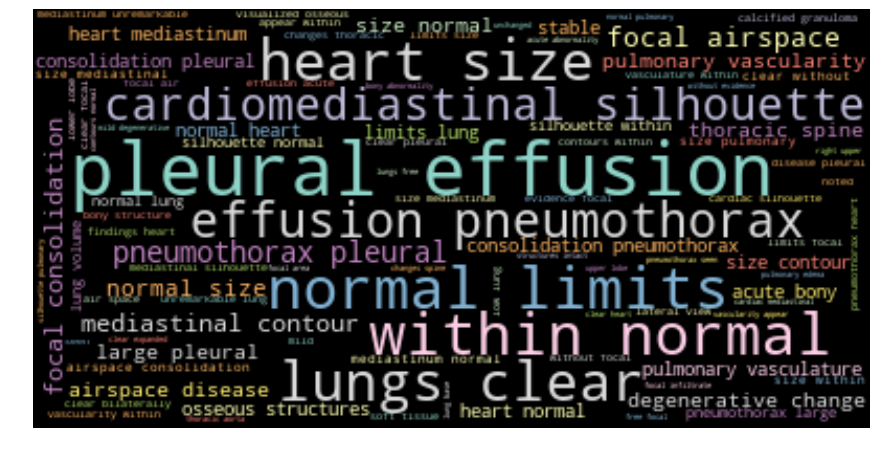

In [86]:
wordcloud = WordCloud(max_words=1000,colormap='Set3', background_color="black").generate(' '.join(data['findings'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

## Word cloud max 1000 words on Impression

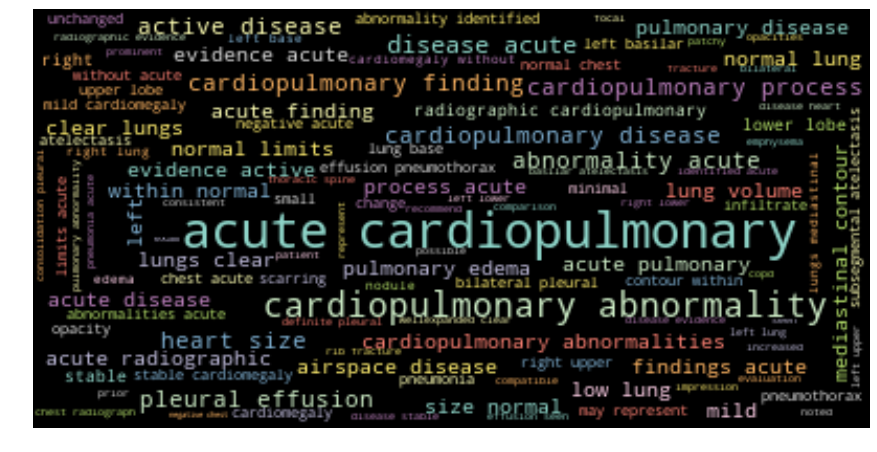

In [87]:
wordcloud = WordCloud(max_words=1000,colormap='Set3', background_color="black").generate(' '.join(data['impression'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

- Above word cloud are generated on the top 1000 max occurrence words.

## Word count distribution

### word count for Findings

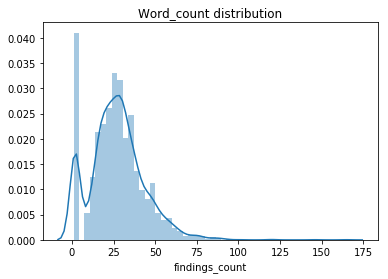

Minimum word count is 1
Maximum word count is 165
median word count is 26.0


In [91]:
sns.distplot(data['findings_count'])
plt.title("Word_count distribution")
plt.show()
print("Minimum word count is {}".format(np.min(data['findings_count'].values)))
print("Maximum word count is {}".format(np.max(data['findings_count'].values)))
print("median word count is {}".format(np.median(data['findings_count'].values)))

- We can see the maximum and minimum word count.
- words max occurrence is 1 that is "No Findings"
- most often word count is between 25 to 30

#### word count for Impression

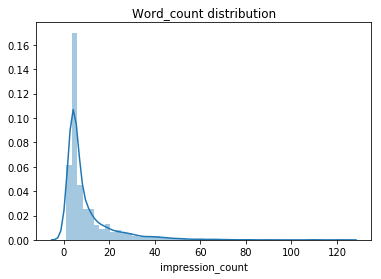

Minimum word count is 1
Maximum word count is 122
median word count is 5.0


In [92]:
sns.distplot(data['impression_count'])
plt.title("Word_count distribution")
plt.show()
print("Minimum word count is {}".format(np.min(data['impression_count'].values)))
print("Maximum word count is {}".format(np.max(data['impression_count'].values)))
print("median word count is {}".format(np.median(data['impression_count'].values)))

- We can see the maximum and minimum word count.
- word count max occurrence is 5
- most often word count is between 5 to 10

In [93]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Word Count findings", "Word Count impression"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(data['findings_count'],i), 3), np.round(np.percentile(data['impression_count'],i), 3)])
print(x)

+------------+---------------------+-----------------------+
| Percentile | Word Count findings | Word Count impression |
+------------+---------------------+-----------------------+
|     0      |         1.0         |          1.0          |
|     5      |         2.0         |          3.0          |
|     10     |         2.0         |          3.0          |
|     15     |         10.0        |          4.0          |
|     20     |         15.0        |          4.0          |
|     25     |         17.0        |          4.0          |
|     30     |         19.0        |          4.0          |
|     35     |         21.0        |          4.0          |
|     40     |         23.0        |          4.0          |
|     45     |         24.0        |          4.0          |
|     50     |         26.0        |          5.0          |
|     55     |         28.0        |          5.0          |
|     60     |         30.0        |          7.0          |
|     65     |         3

- From above percentile value the detailed view of the word count for findings and impression is printed using prettytable.

# 6. EDA on Image data

In [83]:
list(data[324:325]['image_name'])

['CXR1303_IM-0199-2001-0001.png,CXR1303_IM-0199-1001-0001.png,CXR1303_IM-0199-1001-0002.png,CXR1303_IM-0199-2001-0003.png,CXR1303_IM-0199-2001-0002.png']

In [76]:
data[data['image_count'] > 3]

,image_name,image_caption,comparison,indication,findings,impression,findings_count,impression_count,image_count
19,"CXR1015_IM-0013-1001.png,CXR1015_IM-0001-1001....",pa and lateral chest,NaN,female copd exacerbation short of breath,streaky and patchy bibasilar opacities triangu...,bibasilar opacities right greater than left fe...,38,14,4
113,"CXR1102_IM-0069-3001.png,CXR1102_IM-0069-2001....",ap and lateral views of the chest dated,NaN,shortness of breath unable to for lateral view,there is stable cardiomegaly with pulmonary va...,cardiomegaly vascular congestion and probable ...,36,18,4
324,"CXR1303_IM-0199-2001-0001.png,CXR1303_IM-0199-...",chest v frontallateral pm,NaN,bleed,in the interval a cm uncalcified mass has deve...,right upper lobe mass suspicious for neoplasm ...,75,19,5
563,"CXR1525_IM-0340-1001.png,CXR1525_IM-0340-3001....",xray chest pa and lateral,none clinical,NaN,images there is a large hydropneumothorax with...,large left hydropneumothorax with complete col...,83,29,4
1158,"CXR2084_IM-0715-2001-0001.png,CXR2084_IM-0715-...",chest radiograph pa and lateral,none,yr old female with dyspnea,left chest wall mediport placement with venous...,pathologic fractures seen at t and l left veno...,38,12,4
1172,"CXR2097_IM-0727-1001-0001.png,CXR2097_IM-0727-...",chest v frontallateral pm,chest x single view frontal from am,repeat after stab wound,the trachea is midline cardiomediastinal silho...,no acute cardiopulmonary abnormality seen on c...,30,10,4
1329,"CXR2243_IM-0840-4001.png,CXR2243_IM-0840-2001....",pa and lateral chest radiograph,chest radiograph,female with chest pain,the heart is normal size the mediastinum is un...,no acute cardiopulmonary abnormality,40,4,4
1370,"CXR2280_IM-0867-1001-0001.png,CXR2280_IM-0867-...",pa and lateral chest at,none,chest pain,no findings,heart size is normal multiple scattered small ...,2,27,4
1668,"CXR2560_IM-1064-3001.png,CXR2560_IM-1064-4001....",views chest hours,NaN,and chest pain,the cardiomediastinal contours are within norm...,no acute cardiopulmonary abnormality,38,4,4
2457,"CXR3307_IM-1582-1004003.png,CXR3307_IM-1582-10...",xray chest pa and lateral,none,chest pain,the cardiomediastinal silhouette is normal siz...,no acute cardiopulmonary disease,26,4,4


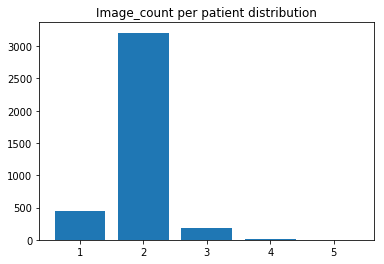

Minimum Image count is 1
Maximum Image count is 5
median Image count is 2.0


In [63]:
plt.bar(data['image_count'].value_counts().index, height=data['image_count'].value_counts().values)
plt.title("Image_count per patient distribution")
plt.show()
print("Minimum Image count is {}".format(np.min(data['image_count'].values)))
print("Maximum Image count is {}".format(np.max(data['image_count'].values)))
print("median Image count is {}".format(np.median(data['image_count'].values)))

- Most occurring image count is 2

==== Displaying random 25 patient X-Ray ====


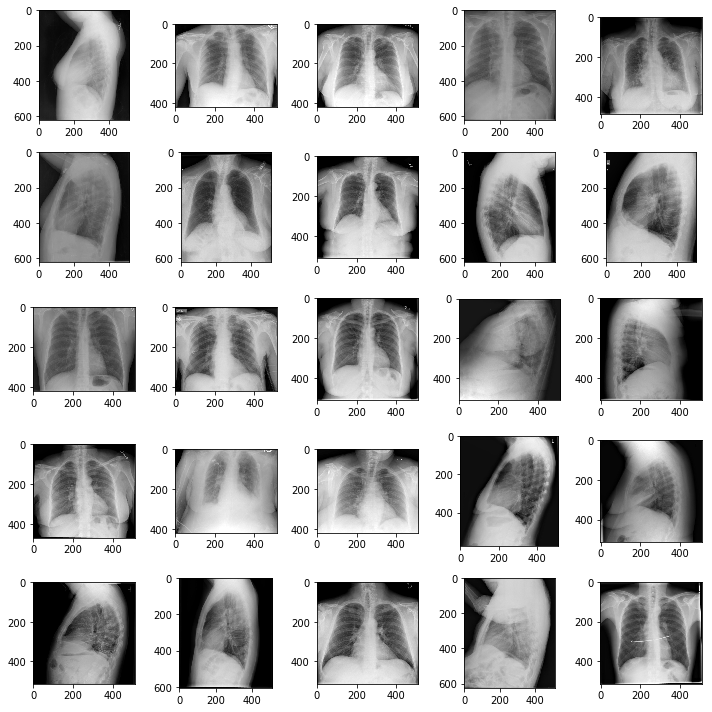

In [111]:
print("==== Displaying random 25 patient X-Ray ====")
fig, axs = plt.subplots(5, 5, figsize = (10,10), tight_layout=True)
for row, subplot in zip(data[0:25].itertuples(), axs.flatten()):
    img=mpimg.imread("img/"+row.image_name.split(',')[0])
    subplot.imshow(img, cmap = 'bone')
plt.show()

In [78]:
def test_img_cap(img_row):
    for i, row in img_row.iterrows():
        imgs = row["image_name"].split(',')
        fig, axs = plt.subplots(1, len(imgs), figsize = (10,10), tight_layout=True)
        count = 0
        for img, subplot in zip(imgs, axs.flatten()):
            img_=mpimg.imread("img/"+img)
            imgplot = axs[count].imshow(img_, cmap = 'bone')
            count +=1
        plt.show()
        
        print("Total Images present for this patient", len(imgs))
        print("="*100)
        print("Findings: Total No of words {} ".format(row['findings_count']))
        print(row['findings'])
        print("="*100)
        print("Impression: Total No of words {} ".format(row['impression_count']))
        print(row['impression'])
        print("="*100)

## visualizing the data row wise

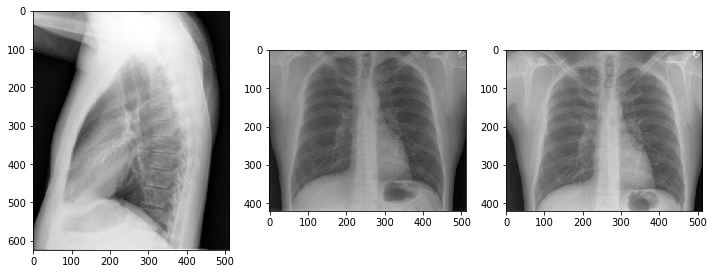

Total Images present for this patient 3
Findings: Total No of words 41 
trachea is midline the cardiomediastinal silhouette is normal the lungs are clear without evidence of acute infiltrate or effusion there is no pneumothorax the visualized bony structures show no acute abnormalities lateral view reveals mild degenerative changes of the thoracic spine
Impression: Total No of words 4 
no acute cardiopulmonary abnormalities


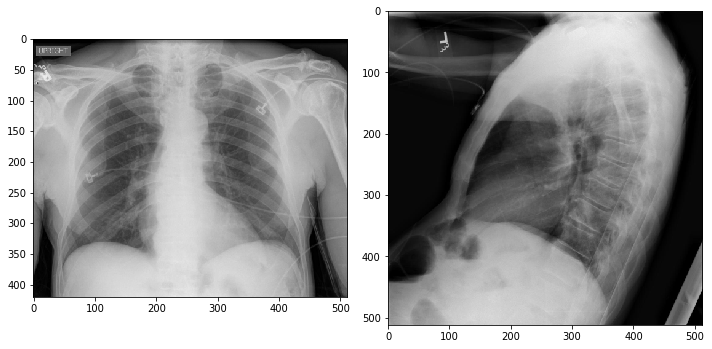

Total Images present for this patient 2
Findings: Total No of words 26 
heart size and mediastinal contours are normal in appearance no consolidative airspace opacities no radiographic evidence of pleural effusion or pneumothorax visualized osseous structures appear intact
Impression: Total No of words 4 
no acute cardiopulmonary abnormality


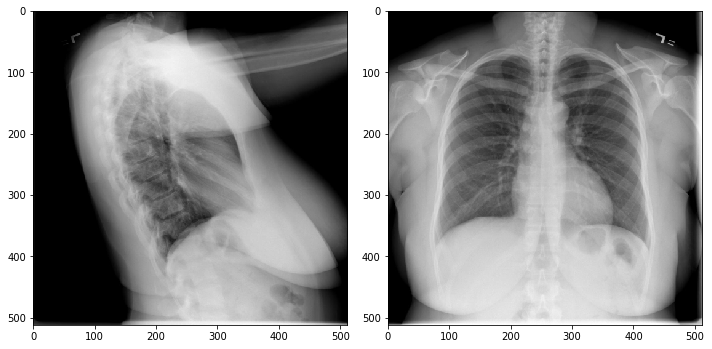

Total Images present for this patient 2
Findings: Total No of words 24 
the cardiomediastinal silhouette and pulmonary vasculature are within normal limits there is no pneumothorax or pleural effusion there are no focal areas of consolidation
Impression: Total No of words 4 
no acute cardiopulmonary abnormality


In [80]:
test_img_cap(data[10:13])

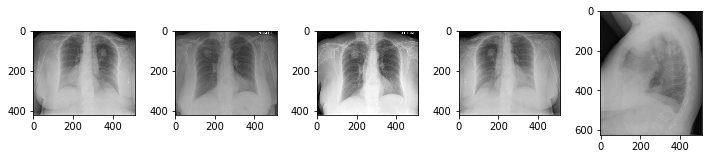

Total Images present for this patient 5
Findings: Total No of words 75 
in the interval a cm uncalcified mass has developed in the posterior segment of the right upper lobe in addition on the pa view an mm opacity is adjacent to the left of the heart this opacity cannot be well identified on the lateral view it may be artifactual but another mass on the left cannot be excluded mediastinum is normal with no evidence for adenopathy heart size normal note of an unchanged hiatal hernia
Impression: Total No of words 19 
right upper lobe mass suspicious for neoplasm ct of chest abdomen and head would be helpful for further evaluation


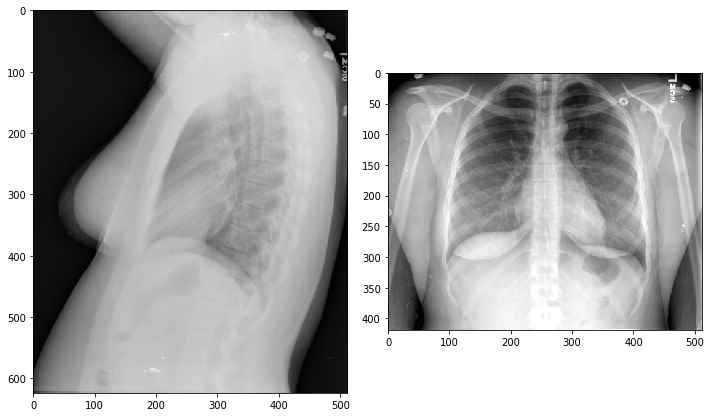

Total Images present for this patient 2
Findings: Total No of words 17 
heart size normal lungs are clear are normal no pneumonia effusions edema pneumothorax adenopathy nodules or masses
Impression: Total No of words 2 
normal chest


In [84]:
test_img_cap(data[324:326])

# 7. Conclusion
- All the raw texts from xml files are parsed and created the dataset.
- Each patient have multiple x-rays associated with them.
- Major finding is the image sequence or number of images associated with each record.
- we have mostly of 2 images per record frontal and lateral. and also we have 3, 4, 5 images associated with each record.
- Other than findings All the features have few missing values.
- There are 543 missing values in findings.
- There is no missing files. We have total of 3955 records and 3 features (Comparison, Indication and Findings) and 1 Impression target variable.
- Most occurring words:
    - Indication: Chest pain
    - Findings: Pleural effusion
    - Impression: acute cardiopulmonary
- Images are in different shapes.
- All the X-Ray images are human upper body particularly about Chest part.
- In text features there are some unknown values like XXXX XXXXX these are replaced with empty string.